# Spaceship Titanic
### Author: James Coffey
### Date: 6/4/2025
### Challenge URL: [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)

In [1]:
import gc
import json
import math
import os
import re
import time

import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from catboost import CatBoostClassifier
from joblib import Parallel, delayed  # optional parallel folds
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingCVClassifier  # pip install mlxtend
from scipy.cluster import hierarchy
from scipy.optimize import minimize
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn import (
    compose,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    neighbors,
    pipeline,
    preprocessing,
    svm,
    tree,
)
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    log_loss,
    roc_auc_score,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_predict,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier

# silence constant-input warnings inside spearmanr, etc.
os.environ["PYTHONWARNINGS"] = "ignore:invalid value encountered in greater:RuntimeWarning"
os.environ["PYTHONWARNINGS"] = "ignore:Found unknown categories:UserWarning"
os.environ["PYTHONWARNINGS"] = "ignore:use_inf_as_na option is:FutureWarning"

sns.set_theme()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.ERROR)

DATA_PATH = "/kaggle/input/spaceship-titanic/"

2025-07-07 18:42:48.133698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751913768.156247    1392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751913768.162967    1392 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# List all “GPU” devices that TensorFlow sees:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("✅ Found GPU(s):")
    for gpu in gpus:
        print("   ", gpu)
else:
    print("❌ No GPU devices detected by TensorFlow.")

✅ Found GPU(s):
    PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
    PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Step 1: Initial Data Exploration and Basic Cleaning

## Load the train dataset

In [3]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test  = pd.read_csv(f"{DATA_PATH}test.csv")

print("Train shape:", train.shape, "  Test shape:", test.shape)

Train shape: (8693, 14)   Test shape: (4277, 13)


## Peek at the first 5 rows

In [4]:
print("--- train.head() ---")
print(train.head())

--- train.head() ---
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False 

## Inspect dtypes and non-null counts

In [5]:
print("--- train.info() ---")
train.info()

--- train.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Identify columns whose dtype might need casting:

e.g.
- PassengerId is an “object” but only used as ID,
- CryoSleep/VIP are boolean-like (object),
- Cabin is “Deck/Num/Side” (string as object).
- Most other numerics look correct.
- We’ll revisit casting after we examine describe().

## Descriptive stats for numeric columns

In [6]:
print("--- train.describe() ---")
print(train.describe())

--- train.describe() ---
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  


## Descriptive stats for categorical columns

In [7]:
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
print("--- train[cat_cols].describe() ---")
print(train[cat_cols].describe())

--- train[cat_cols].describe() ---
       PassengerId HomePlanet CryoSleep    Cabin  Destination    VIP  \
count         8693       8492      8476     8494         8511   8490   
unique        8693          3         2     6560            3      2   
top        9280_02      Earth     False  G/734/S  TRAPPIST-1e  False   
freq             1       4602      5439        8         5915   8291   

                      Name  
count                 8493  
unique                8473  
top     Ankalik Nateansive  
freq                     2  


## Count of missing values, sorted descending

In [8]:
print("--- train.isnull().sum().sort_values(ascending=False) ---")
print(train.isnull().sum().sort_values(ascending=False))

--- train.isnull().sum().sort_values(ascending=False) ---
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


## Split "Cabin" into Deck, CabinNum, Side

In [9]:
# Format is typically "B/123/S" or NaN
cabin_split = train["Cabin"].fillna("U/9999/U").str.split("/", expand=True)
train["Deck"] = cabin_split[0].replace("U", np.nan)
train["CabinNum"] = pd.to_numeric(cabin_split[1], errors="coerce").replace(9999, np.nan)
train["Side"] = cabin_split[2].replace("U", np.nan)

## Check missing‐counts for the newly created Deck, CabinNum, Side

In [10]:
print("\n--- Missing counts in Deck/CabinNum/Side ---")
print(
    pd.Series(
        {
            "Deck": train["Deck"].isnull().sum(),
            "CabinNum": train["CabinNum"].isnull().sum(),
            "Side": train["Side"].isnull().sum(),
        }
    )
)


--- Missing counts in Deck/CabinNum/Side ---
Deck        199
CabinNum    199
Side        199
dtype: int64


You can see that `Deck`, `CabinNum`, and `Side` have 199 missing values matching the missing values from `Cabin`. This shows that for every value of `Cabin` that was present, there was a complete entry.

## Extract GroupNum from PassengerId; compute GroupSize

In [11]:
pid_split = train["PassengerId"].str.extract(r"(\d{4})_(\d{2})")
train["GroupNum"] = pid_split[0].astype(int)
train["GroupSize"] = train.groupby("GroupNum")["PassengerId"].transform("count")

## Extract Surname from Name

In [12]:
train["Surname"] = train["Name"].str.split().str[-1]  # NaN → NaN

## Drop unused identifier columns

In [13]:
train = train.drop(columns=["Cabin", "PassengerId", "Name"])
print("After dropping Cabin, PassengerId, Name →", train.shape)

After dropping Cabin, PassengerId, Name → (8693, 17)


## Recompute descriptive statistics

In [14]:
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("\n--- Numeric features describe() ---")
print(train[numeric_cols].describe().T)


--- Numeric features describe() ---
               count         mean          std  min      25%     50%     75%  \
Age           8514.0    28.827930    14.489021  0.0    19.00    27.0    38.0   
RoomService   8512.0   224.687617   666.717663  0.0     0.00     0.0    47.0   
FoodCourt     8510.0   458.077203  1611.489240  0.0     0.00     0.0    76.0   
ShoppingMall  8485.0   173.729169   604.696458  0.0     0.00     0.0    27.0   
Spa           8510.0   311.138778  1136.705535  0.0     0.00     0.0    59.0   
VRDeck        8505.0   304.854791  1145.717189  0.0     0.00     0.0    46.0   
CabinNum      8494.0   600.367671   511.867226  0.0   167.25   427.0   999.0   
GroupNum      8693.0  4633.389624  2671.028856  1.0  2319.00  4630.0  6883.0   
GroupSize     8693.0     2.035546     1.596347  1.0     1.00     1.0     3.0   

                  max  
Age              79.0  
RoomService   14327.0  
FoodCourt     29813.0  
ShoppingMall  23492.0  
Spa           22408.0  
VRDeck        2413

In [15]:
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
print("\n--- Categorical features describe() ---")
print(train[categorical_cols].describe())


--- Categorical features describe() ---
       HomePlanet CryoSleep  Destination    VIP  Deck  Side    Surname
count        8492      8476         8511   8490  8494  8494       8493
unique          3         2            3      2     8     2       2217
top         Earth     False  TRAPPIST-1e  False     F     S  Casonston
freq         4602      5439         5915   8291  2794  4288         18


## Bar chart of target class balance

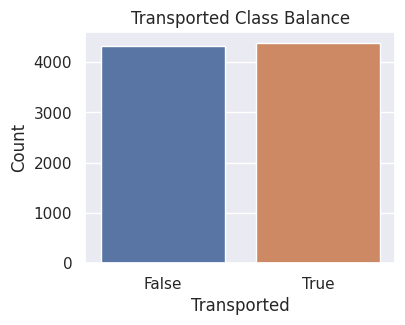

In [16]:
plt.figure(figsize=(4, 3))
sns.countplot(x="Transported", data=train)
plt.title("Transported Class Balance")
plt.xlabel("Transported")
plt.ylabel("Count")
plt.show()

## Histograms for all numeric features (excluding ID and label)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

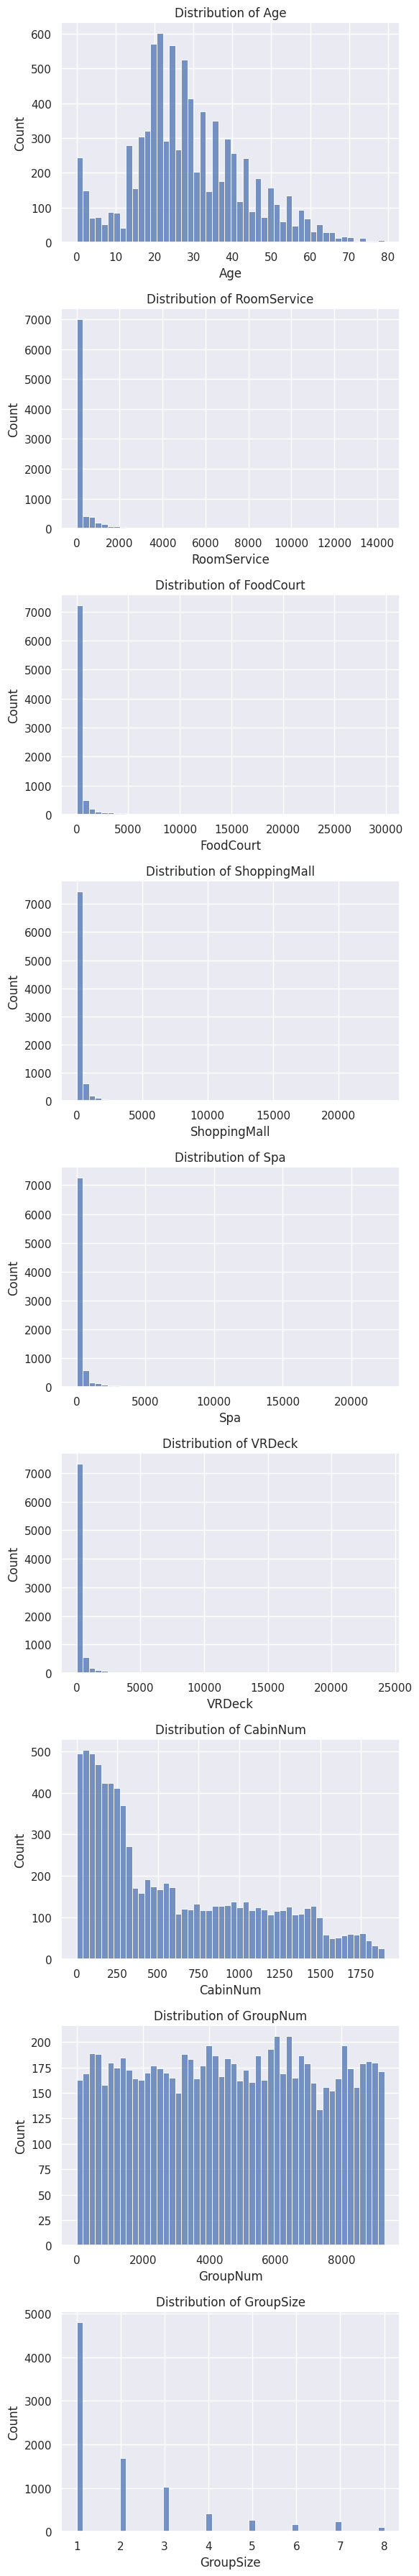

In [17]:
num_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()

fig, axes = plt.subplots(len(num_cols), 1, figsize=(6, 4 * len(num_cols)))
for i, col in enumerate(num_cols):
    sns.histplot(train[col].dropna(), bins=50, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Here’s a quick rundown of what those plots are telling us feature by feature:

1. **Age**

   * Right-skewed and multimodal: a big cluster of young adults in their 20s–30s, a secondary bump in childhood (around 5–10 years old), and a long tail out to \~80.
   * A small spike at zero (infant/young children).
   * **Implication:** consider age-bins (e.g. child, young adult, mid-age, senior) rather than treating as purely continuous.

2. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**

   * **Extreme zero‐inflation:** the vast majority of passengers spent nothing in each category.
   * **Heavy right tails:** a few very big spenders (up to \~15 000 on RoomService, \~30 000 on FoodCourt, etc.).
   * **Implication:**

     * Split into “spent vs. didn’t spend” binary flags.
     * Log-transform or cap the large values (e.g. `log1p`) to tame the tail.
     * Possibly engineer “total spend” and fractional spend ratios.

3. **CabinNum**

   * Most cabin numbers cluster at low to mid values (0–2000), with a handful up to \~10 000.
   * A very tall bar at exactly 9999—that’s our placeholder for missing cabins (`fillna("U/9999/U")`).
   * **Implication:**

     * Treat “9999” as its own category (i.e. “No cabin assigned”).
     * Otherwise bin cabin numbers (deciles or custom ranges) or extract deck/side instead of numeric cabin alone.

4. **GroupNum**

   * Nearly uniform across its range (0–9000). That’s expected: group numbers are simply arbitrary IDs.
   * **Implication:** drop it or only use it to derive **GroupSize** and any group‐level stats (e.g. cryo‐sleep fraction).

5. **GroupSize**

   * **Highly skewed toward 1:** most passengers are traveling alone.
   * Diminishing counts at size 2, 3, 4… up to 8.
   * **Implication:** One-hot or bucketize group size (e.g. alone vs. small group vs. large group), or use as a numeric “family size” feature.

---

**Summary of next steps based on these distributions:**

* **Age →** bucket into a few meaningful age groups.
* **Spending columns →**

  * Add `HasSpent_X` = whether they spent >0 in each amenity.
  * Create `TotalSpend = RoomService+…+VRDeck` and maybe `LogTotalSpend = log1p(TotalSpend)`.
  * Compute fractional spend per amenity if useful (`RoomService/TotalSpend`, etc.).
* **CabinNum →** turn the 9999 “missing” bar into its own category, or bin into ranges + “Missing.”
* **GroupSize →** engineer “IsAlone” (size=1), “SmallGroup,” “LargeGroup,” etc., instead of raw ID.

These transformations will turn those heavily skewed and zero-inflated features into more model-friendly inputs.

## Value‐counts for categorical features (including newly split ones)

In [18]:
all_cat = train.select_dtypes(include=["object"]).columns.tolist()
for col in all_cat:
    print(f"\n--- Value counts for {col} ---")
    print(train[col].fillna("Missing").value_counts().head(10))


--- Value counts for HomePlanet ---
HomePlanet
Earth      4602
Europa     2131
Mars       1759
Missing     201
Name: count, dtype: int64

--- Value counts for CryoSleep ---
CryoSleep
False      5439
True       3037
Missing     217
Name: count, dtype: int64

--- Value counts for Destination ---
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Missing           182
Name: count, dtype: int64

--- Value counts for VIP ---
VIP
False      8291
Missing     203
True        199
Name: count, dtype: int64

--- Value counts for Deck ---
Deck
F          2794
G          2559
E           876
B           779
C           747
D           478
A           256
Missing     199
T             5
Name: count, dtype: int64

--- Value counts for Side ---
Side
S          4288
P          4206
Missing     199
Name: count, dtype: int64

--- Value counts for Surname ---
Surname
Missing       200
Casonston      18
Oneiles        16
Domington      15
Litthews       15
Garnes         14
Full

# Convert Boolean to Integer

In [19]:
train["Transported"] = train["Transported"].astype(int)

# Missing Value Imputation

In [20]:
# Age
train["Age"] = train["Age"].fillna(train["Age"].median())

# Spending categories
for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    train[col] = train[col].fillna(0)

# CabinNum
train["CabinNum"] = train["CabinNum"].fillna(-1)
train["CabinNum_NA"] = (train["CabinNum"] == -1).astype(int)

# Other categorical features
for col in ["HomePlanet", "Destination", "Deck", "Side", "Surname"]:
    train[col] = train[col].fillna("Missing")

# Binaries features
train["CryoSleep_NA"] = train["CryoSleep"].isnull().astype(int)
train["CryoSleep"] = train["CryoSleep"].fillna(0).astype(int)
train["VIP_NA"] = train["VIP"].isnull().astype(int)
train["VIP"] = train["VIP"].fillna(0).astype(int)

# Count of missing values total
print(f"Count of missing values after imputation: {train.isnull().sum().sum()}")

Count of missing values after imputation: 0


# Make numeric features Gaussian like

In [21]:
for col in ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNum", "GroupSize"]:
    
    transforms = [
        ("raw",         lambda x: x),
        ("log1p",       lambda x: np.log1p(x.clip(lower=0))),
        ("exp",         lambda x: np.exp(x.clip(upper=20))),
        ("inv",         lambda x: 1.0 / (x + 1e-2)),
        ("sqrt",        lambda x: np.sqrt(x.clip(lower=0))),
        ("square",      lambda x: x**2),
        ("cuberoot",    lambda x: np.cbrt(x)),
        ("box-cox",     lambda x: pd.Series(stats.boxcox(x.clip(lower=0) + 1e-6)[0])),
        ("yeo-johnson", lambda x: pd.Series(stats.yeojohnson(x)[0])),
    ]

    for name, fn in transforms:
        trf_col = fn(train[col])
        sw_pvalue = stats.shapiro(trf_col.sample(5000, random_state=42)).pvalue
        if sw_pvalue > 0.05:
            plt.figure(figsize=(15,6))
            plt.suptitle(f"{col}_{name}")
            plt.subplot(1, 2, 1)
            trf_col.hist()

            plt.subplot(1, 2, 2)
            stats.probplot(trf_col, dist="norm", plot=pylab)
            plt.show()
            
            print(f"Shapiro-Wilk test p-value: {sw_pvalue}")
            print("Fail to reject null hypothesis\nData may be normally distributed.")

As none of the above printed. It looks like the transforms could not make the numeric features Gaussian like. This is okay, as I will be using tree models.

# Outliers

## Identify Outliers

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   int64  
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int64  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   int64  
 11  Deck          8693 non-null   object 
 12  CabinNum      8693 non-null   float64
 13  Side          8693 non-null   object 
 14  GroupNum      8693 non-null   int64  
 15  GroupSize     8693 non-null   int64  
 16  Surname       8693 non-null   object 
 17  CabinNum_NA   8693 non-null   int64  
 18  CryoSleep_NA  8693 non-null 

I am looking at the above and identify the continuous columns for identifying outliers. That is: `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`, `CabinNum`, and `GroupSize`.

I am looking at two definitions of outliers. The first is if a value deviates from the mean by more than three times the standard deviation (aka. the "Three Sigma Rule"). The other is Tukey's fences defined by 1.5 times the IQR below the lower and upper quartiles (ie. Q1 and Q3).

In [23]:
cont_cols = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "CabinNum",
    "GroupSize",
]

outlier_summary = []

for col in cont_cols:
    series = train[col].dropna().astype(float)

    # Gaussian bounds
    mu, sigma = series.mean(), series.std()
    gauss_lower, gauss_upper = mu - 3 * sigma, mu + 3 * sigma

    # IQR bounds
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    iqr_lower, iqr_upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    # counts
    total = len(series)
    gauss_out = ((series < gauss_lower) | (series > gauss_upper)).sum()
    iqr_out = ((series < iqr_lower) | (series > iqr_upper)).sum()

    outlier_summary.append(
        {
            "feature": col,
            "count": total,
            "gauss_lower": round(gauss_lower, 2),
            "gauss_upper": round(gauss_upper, 2),
            "gauss_out": gauss_out,
            "iqr_lower": round(iqr_lower, 2),
            "iqr_upper": round(iqr_upper, 2),
            "iqr_out": iqr_out,
        }
    )

out_df = pd.DataFrame(outlier_summary).set_index("feature")
print(out_df)

              count  gauss_lower  gauss_upper  gauss_out  iqr_lower  \
feature                                                               
Age            8693       -14.23        71.81         30       -5.5   
RoomService    8693     -1761.55      2201.57        175      -61.5   
FoodCourt      8693     -4338.94      5235.81        167      -91.5   
ShoppingMall   8693     -1624.45      1963.59        130      -33.0   
Spa            8693     -3072.10      3681.28        176      -79.5   
VRDeck         8693     -3104.12      3700.64        166      -60.0   
CabinNum       8693      -955.12      2128.32          0    -1094.5   
GroupSize      8693        -2.75         6.82        335       -2.0   

              iqr_upper  iqr_out  
feature                           
Age                62.5      162  
RoomService       102.5     1906  
FoodCourt         152.5     1916  
ShoppingMall       55.0     1879  
Spa               132.5     1833  
VRDeck            100.0     1849  
CabinNum 

The Three Sigma Rule and Tukey's fences aren't really a good measures of outliers in this case as we established before that these distributions are not normal. For exammple, the spending features are dominated by 0. It's best to discretize these features rather than drop "outliers".

# Discretization

Below, I use `pd.qcut` and `pd.cut` to discretize each of these non-Gaussian continuous features into bins.

In [24]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side,GroupNum,GroupSize,Surname,CabinNum_NA,CryoSleep_NA,VIP_NA
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P,1,1,Ofracculy,0,0,0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S,2,1,Vines,0,0,0
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S,3,2,Susent,0,0,0
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S,3,2,Susent,0,0,0
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S,4,1,Santantines,0,0,0


In [25]:
train["Age_qbin"] = pd.qcut(train.Age, 6, labels=False)

for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    nonzero = train.loc[train[col]>0, col]
    cuts = pd.qcut(nonzero, 3, labels=["low","med","high"])
    train.loc[train[col]>0, f"{col}_bin"] = cuts
    train[f"{col}_bin"] = train[f"{col}_bin"].cat.add_categories("zero").fillna("zero")

# CabinNum == -1 marks "missing"
mask = train.CabinNum >= 0

# Create the 5 quantile bins on just the real cabin numbers
train.loc[mask, "CabinNum_qbin"] = pd.qcut(
    train.loc[mask, "CabinNum"],
    q=5,
    labels=False,
    duplicates="drop"      # in case some quantiles collapse
)

# Everything that was -1 gets its own bin: CabinNum_qbin ∈ {-1, 0,1,2,3,4}
train["CabinNum_qbin"] = train["CabinNum_qbin"].fillna(-1).astype(int)

train["GroupSize_bin"] = pd.cut(
    train.GroupSize, 
    bins=[0,1,2,4,10,np.inf], 
    labels=["alone","pair","small(3-4)","medium(5-10)","large(>10)"]
)

train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,CryoSleep_NA,VIP_NA,Age_qbin,RoomService_bin,FoodCourt_bin,ShoppingMall_bin,Spa_bin,VRDeck_bin,CabinNum_qbin,GroupSize_bin
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,4,zero,zero,zero,zero,zero,0,alone
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,...,0,0,2,med,low,low,med,low,0,alone
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,...,0,0,5,low,high,zero,high,low,0,pair
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,...,0,0,3,zero,high,med,high,med,0,pair
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,...,0,0,0,med,low,med,med,low,0,alone


In [26]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   HomePlanet        8693 non-null   object  
 1   CryoSleep         8693 non-null   int64   
 2   Destination       8693 non-null   object  
 3   Age               8693 non-null   float64 
 4   VIP               8693 non-null   int64   
 5   RoomService       8693 non-null   float64 
 6   FoodCourt         8693 non-null   float64 
 7   ShoppingMall      8693 non-null   float64 
 8   Spa               8693 non-null   float64 
 9   VRDeck            8693 non-null   float64 
 10  Transported       8693 non-null   int64   
 11  Deck              8693 non-null   object  
 12  CabinNum          8693 non-null   float64 
 13  Side              8693 non-null   object  
 14  GroupNum          8693 non-null   int64   
 15  GroupSize         8693 non-null   int64   
 16  Surname           8693 n

# Pipeline Creation

From the Exploratory Data Analysis and Feature Engineering steps above, I put these into a pipeline that can be called during cross validation to prevent data leakage. I add some new engineered features as well. These are derivative of the base features engineered above.

In [27]:
# ============================================================
# 1. Helpers
# ============================================================
CABIN_RE = re.compile(r"(?P<deck>[A-Z])/(?P<num>\d+)/(?P<side>[PS])")
GROUP_RE = re.compile(r"(\d{4})_(\d{2})")
SPEND    = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def _row_featurize(df: pd.DataFrame) -> pd.DataFrame:
    """Per-row features – NO look-ahead."""
    df = df.copy()

    # ── Cabin split ──────────────────────────────────────────
    cabin           = df["Cabin"].str.extract(CABIN_RE)
    df["Deck"]      = cabin["deck"]                # NaN kept as NaN
    df["Side"]      = cabin["side"]
    df["CabinNum"]  = cabin["num"].astype(float)

    # ── Group id / size ──────────────────────────────────────
    gnum            = df["PassengerId"].str.extract(GROUP_RE).astype(int)[0]
    df["GroupNum"]  = gnum
    df["GroupSize"] = df.groupby("GroupNum")["PassengerId"].transform("size")

    # ── Spending raw / ratios ────────────────────────────────
    df[SPEND]             = df[SPEND].fillna(0)
    df["TotalSpend"]      = df[SPEND].sum(axis=1)
    df["SpendPerPerson"]  = df["TotalSpend"] / df["GroupSize"].clip(lower=1)

    for col in SPEND:
        df[f"{col}Ratio"] = np.where(df["TotalSpend"]>0,
                                     df[col]/df["TotalSpend"], 0.0)

    # ── Binary flags (keep NaN for flag first) ───────────────
    df["CryoSleep_NA"] = df["CryoSleep"].isna().astype(int)
    df["VIP_NA"]       = df["VIP"].isna().astype(int)
    df["CabinNum_NA"]  = df["CabinNum"].isna().astype(int)

    df["CryoSleep"] = df["CryoSleep"].fillna(0).astype(int)
    df["VIP"]       = df["VIP"].fillna(0).astype(int)
    df["CabinNum"]  = df["CabinNum"].fillna(-1)

    # ── Surname ──────────────────────────────────────────────
    df["Surname"] = df["Name"].str.split().str[-1]

    # ── Categorical NaNs ──────────────────────────────────────
    for c in ["HomePlanet","Destination","Deck","Side","Surname"]:
        df[c] = df[c].fillna("Missing").astype(str)

    # ── Crosses ──────────────────────────────────────────────
    df["DeckSide"] = df["Deck"] + "_" + df["Side"]
    df["HomeDest"] = df["HomePlanet"] + "_" + df["Destination"]

    # ── Drop IDs ─────────────────────────────────────────────
    df = df.drop(columns=["Cabin","PassengerId","Name"])

    return df

# ============================================================
# Transformer v2 (adds solo, family-size, age buckets,
#                              deck geometry, luxury spend, Cryo-x-…)
# ============================================================
class SpaceshipTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq=0.01, n_age_bins=6,
                 n_spend_bins=3, n_cabin_bins=5,
                 n_tot_bins=5, n_group_bins=5, use_fixed_group_bins=True, drop_cols=None):
        self.min_freq = min_freq
        self.n_age_bins = n_age_bins
        self.n_spend_bins = n_spend_bins
        self.n_cabin_bins = n_cabin_bins
        self.n_tot_bins   = n_tot_bins
        self.n_group_bins = n_group_bins
        self.use_fixed_group_bins = use_fixed_group_bins
        self.fixed_grp_edges_ = [0, 1, 2, 4, 10, np.inf]  # domain-knowledge edges
        self.drop_cols = drop_cols or ["GroupNum"]          # list of col names

    # ---------- fit ------------------------------------------------------
    def fit(self, X, y=None):
        df = _row_featurize(X)

        # surname counts
        self.surname_cnt_ = df["Surname"].value_counts().to_dict()

        # numeric bins / imputers
        self.age_median_ = df["Age"].median()
        self.age_edges_  = np.quantile(df["Age"].fillna(self.age_median_),
                                       np.linspace(0,1,self.n_age_bins+1))
        
        nonzero_tot   = df.loc[df["TotalSpend"] > 0, "TotalSpend"]
        self.tot_edges_ = np.quantile(nonzero_tot,
                                      np.linspace(0, 1, self.n_spend_bins + 1))
        
        nonzero_pp = df.loc[df["SpendPerPerson"] > 0, "SpendPerPerson"]
        self.spp_edges_ = np.quantile(nonzero_pp,
                                      np.linspace(0, 1, self.n_spend_bins + 1))
        
        if self.use_fixed_group_bins:
            self.group_edges_ = self.fixed_grp_edges_
        else:
            self.group_edges_ = np.quantile(df["GroupSize"],
                                            np.linspace(0,1,self.n_group_bins+1))

        self.spend_edges_ = {}
        for col in SPEND:
            nz = df.loc[df[col]>0, col]
            q  = np.linspace(0,1,self.n_spend_bins+1)
            self.spend_edges_[col] = np.quantile(nz if len(nz) else [0], q)

        mask = df["CabinNum"]>=0
        self.cabinnum_edges_ = np.quantile(df.loc[mask,"CabinNum"],
                                           np.linspace(0,1,self.n_cabin_bins+1))

        # group agg
        grp = df.groupby("GroupNum")
        self.group_age_median_ = grp["Age"].median().to_dict()
        self.group_cryo_frac_  = grp["CryoSleep"].mean().to_dict()
        self.family_age_gap_   = grp["Age"].agg(lambda s: s.max()-s.min()).to_dict()

        # rare-cat tables
        self.freq_ = {c: df[c].value_counts() for c in df.select_dtypes("object")}

        # one preview for OHE / scaler
        tmp = self._apply_transforms(df)
        self.cat_cols_ = tmp.select_dtypes("object").columns.tolist()
        self.num_cols_ = tmp.select_dtypes(["int64","float64"]).columns.tolist()

        self.ohe_    = OneHotEncoder(drop="first", sparse_output=False,
                                     handle_unknown="ignore").fit(tmp[self.cat_cols_])
        self.scaler_ = StandardScaler().fit(tmp[["TotalSpend"]])

        full_names = np.concatenate([self.num_cols_,
                                     self.ohe_.get_feature_names_out(self.cat_cols_)])
        self._post_drop_idx_ = [i for i, f in enumerate(full_names)
                                if f in self.drop_cols]

        return self

    # ---------- transform ------------------------------------------------
    def transform(self, X):
        df = self._apply_transforms(_row_featurize(X))

        X_cat = self.ohe_.transform(df[self.cat_cols_])
        df["TotalSpend"] = self.scaler_.transform(df[["TotalSpend"]])
        X_num = df[self.num_cols_].to_numpy()

        X = np.hstack([X_num, X_cat])

        if self._post_drop_idx_:
            X = np.delete(X, self._post_drop_idx_, axis=1)
        
        return X

    # ---------- helper ---------------------------------------------------
    def _apply_transforms(self, d):
        d = d.copy()

        # Age impute + bin
        d["Age"] = d["Age"].fillna(self.age_median_)
        d["Age_qbin"] = pd.cut(d["Age"], self.age_edges_,
                               labels=False, include_lowest=True)
        # Age domain buckets (children / teen / YA / 26-30 / 31-50 / 51+)
        d["Age_group_dom"] = pd.cut(d["Age"], bins=[0, 12, 18, 25, 30, 50, 100],
                                    labels=[0, 1, 2, 3, 4, 5], include_lowest=True).astype(int)

        # family size via surname (if NA, assume alone)
        d["FamilySize"] = d["Surname"].map(self.surname_cnt_).fillna(1)

        # luxury spending
        d["LuxurySpend"] = d["Spa"] + d["VRDeck"]

        # deck geometry
        deck_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
        d["DeckLevel"] = d["Deck"].map(deck_map).fillna(0).astype(int)
        d["CabinSection"] = pd.cut(d["CabinNum"],
                                   bins=[-1, 300, 600, 900, 2000],
                                   labels=[0, 1, 2, 3]).cat.add_categories([4]).fillna(4).astype(int)
        d["DeckDistMid"] = (d["DeckLevel"] - 4).abs()
        d["PremiumCabin"] = ((d["DeckLevel"] <= 3) & (d["CabinSection"] == 1)).astype(int)

        # solo flag
        d["IsSolo"] = (d["GroupSize"] == 1).astype(int)
        
        # GroupSize bin
        d["GroupSize_bin"] = pd.cut(d["GroupSize"], self.group_edges_, 
                                    labels=False, include_lowest=True)

        for col, edges in [("TotalSpend", self.tot_edges_),
                           ("SpendPerPerson", self.spp_edges_)]:
            bin_col = f"{col}_bin"
            d[bin_col] = 0 # 0  →  “zero spend”
            mask = d[col] > 0
            d.loc[mask, bin_col] = (
                pd.cut(
                    d.loc[mask, col],
                    bins=edges,
                    labels=False,
                    include_lowest=True
                ) + 1 # shift so 1/2/3 = low/med/high
            )

        # Spend bins
        for col in SPEND:
            d[f"{col}_bin"] = 0 
            mask = d[col] > 0
            d.loc[mask, f"{col}_bin"] = (
                pd.cut(
                    d.loc[mask, col],
                    bins=self.spend_edges_[col],
                    labels=False,
                    include_lowest=True
                ) + 1 # 1=low,2=med,3=high
            )

        # CabinNum bins
        mask = d["CabinNum"]>=0
        d["CabinNum_qbin"] = -1
        d.loc[mask, "CabinNum_qbin"] = pd.cut(
            d.loc[mask,"CabinNum"], self.cabinnum_edges_,
            labels=False, include_lowest=True
        ).fillna(-1).astype(int)

        # CryoSleep interactions (cheap pairwise)
        for feat in ["Age", "DeckLevel", "GroupSize"]:
            d[f"Cryo_x_{feat}"] = d["CryoSleep"] * d[feat]

        # Group-level
        d["GroupAgeMedian"] = d["GroupNum"].map(self.group_age_median_)
        d["GroupCryoFrac"]  = d["GroupNum"].map(self.group_cryo_frac_)
        d["FamilyAgeGap"]   = d["GroupNum"].map(self.family_age_gap_)

        # Missing groups (i.e. groups that appear only in the validation / test set) will get NaN
        d[["GroupAgeMedian","GroupCryoFrac","FamilyAgeGap"]] = \
            d[["GroupAgeMedian","GroupCryoFrac","FamilyAgeGap"]].fillna(-1)

        # Rare-category collapse
        for col,freq in self.freq_.items():
            rare = freq[freq < self.min_freq * len(freq)].index
            d[col] = np.where(d[col].isin(freq.index), d[col], "Other")
            d[col] = np.where(d[col].isin(rare), "Other", d[col])
        
        d = d.drop(columns=[c for c in self.drop_cols if c in d.columns])

        d = d.fillna(-1)          # guarantees no NaN leaves the transformer

        return d

    def get_feature_names_out(self, input_features=None):
        """
        scikit-learn asks for this to expose the names after transform().
        """
        if not hasattr(self, "ohe_"):
            raise RuntimeError("Must call .fit() first")
        names = np.concatenate([self.num_cols_,
                                self.ohe_.get_feature_names_out(self.cat_cols_)])
        if hasattr(self, "_post_drop_idx_"):
            names = np.delete(names, self._post_drop_idx_)
        return names

# Remove Collinear Features

In [28]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
X = train.drop(columns="Transported")
y = train["Transported"].astype(int)
tfm = SpaceshipTransformer(min_freq=0.01)
X = tfm.fit_transform(X)
feat_names = tfm.get_feature_names_out()
df = pd.DataFrame(X, columns=feat_names)

num_like = df.select_dtypes(["int64","float64"]).columns
# keep only genuinely numeric features (optionally also keep q-bins)
keep = [c for c in num_like
        if not any(c.startswith(prefix + "_") for prefix in tfm.cat_cols_)]
df = df[keep]

# prop zero-variance columns before correlation
const = df.columns[df.nunique() == 1]
df  = df.drop(columns=const)

# Spearman correlation via SciPy
# axis=0  → columns are variables, rows are observations
rho, pval = spearmanr(df.to_numpy(), axis=0)   # returns ndarray
corr = pd.DataFrame(rho, index=df.columns, columns=df.columns)

# NaN appears whenever a column is constant (already handled) or two
# columns are both constant.  Replace with 0 for the distance calc.
corr = corr.fillna(0).astype(float)

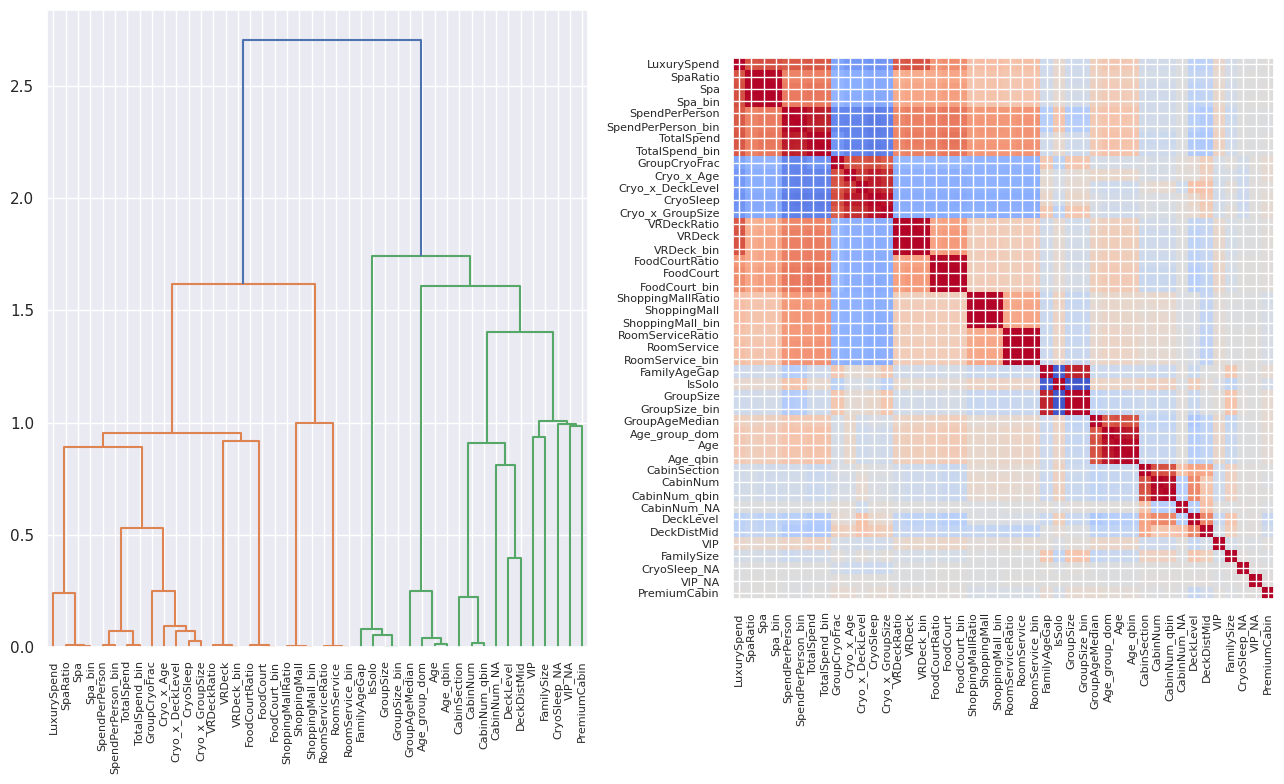

In [29]:
# ρ ➜ distance
dist = 1 - np.abs(corr)

# --- make it machine-perfect symmetric & zero-diagonal -------------
dist = (dist + dist.T) / 2.0          # force symmetry
np.fill_diagonal(dist.values, 0.0)    # zero on the diagonal

# condensed vector for linkage
linkage = hierarchy.ward(squareform(dist))

fig, (axd, axh) = plt.subplots(1, 2, figsize=(13, 8))
dend = hierarchy.dendrogram(linkage, labels=corr.columns, ax=axd,
                            leaf_rotation=90, leaf_font_size=8)

idx = dend["leaves"]
axh.imshow(corr.values[idx][:, idx], vmin=-1, vmax=1, cmap="coolwarm")
axh.set_xticks(range(len(idx))); axh.set_yticks(range(len(idx)))
axh.set_xticklabels(np.array(df.columns)[idx], rotation=90, fontsize=8)
axh.set_yticklabels(np.array(df.columns)[idx], fontsize=8)
fig.tight_layout(); plt.show()

In [30]:
# upper-triangle mask
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))

# choose a threshold –  │ρ│ > 0.90 is common
to_drop = [c for c in upper.columns if (upper[c].abs() > 0.90).any()]
print("Highly collinear:", to_drop)

Highly collinear: ['SpendPerPerson', 'RoomServiceRatio', 'FoodCourtRatio', 'ShoppingMallRatio', 'SpaRatio', 'VRDeckRatio', 'Age_qbin', 'Age_group_dom', 'IsSolo', 'GroupSize_bin', 'TotalSpend_bin', 'SpendPerPerson_bin', 'RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin', 'VRDeck_bin', 'CabinNum_qbin', 'Cryo_x_Age', 'Cryo_x_DeckLevel', 'Cryo_x_GroupSize', 'FamilyAgeGap']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [31]:
# choose a threshold
thr = 0.90

# ----------------------------------------------------------------
# 1) boolean mask: True where |ρ| > threshold (exclude self-corr)
# ----------------------------------------------------------------
high = corr.abs() > thr
np.fill_diagonal(high.values, False)

# ----------------------------------------------------------------
# 2) collect partners for every flagged feature
# ----------------------------------------------------------------
partners = {
    col: corr.columns[high.loc[col]].tolist()
    for col in to_drop
    if high.loc[col].any()
}

# Pretty print
for k, v in partners.items():
    print(f"{k:20s}  ↔  {v}")

SpendPerPerson        ↔  ['TotalSpend', 'TotalSpend_bin', 'SpendPerPerson_bin']
RoomServiceRatio      ↔  ['RoomService', 'RoomService_bin']
FoodCourtRatio        ↔  ['FoodCourt', 'FoodCourt_bin']
ShoppingMallRatio     ↔  ['ShoppingMall', 'ShoppingMall_bin']
SpaRatio              ↔  ['Spa', 'Spa_bin']
VRDeckRatio           ↔  ['VRDeck', 'VRDeck_bin']
Age_qbin              ↔  ['Age', 'Age_group_dom']
Age_group_dom         ↔  ['Age', 'Age_qbin']
IsSolo                ↔  ['GroupSize', 'GroupSize_bin', 'FamilyAgeGap']
GroupSize_bin         ↔  ['GroupSize', 'IsSolo', 'FamilyAgeGap']
TotalSpend_bin        ↔  ['TotalSpend', 'SpendPerPerson', 'SpendPerPerson_bin']
SpendPerPerson_bin    ↔  ['TotalSpend', 'SpendPerPerson', 'TotalSpend_bin']
RoomService_bin       ↔  ['RoomService', 'RoomServiceRatio']
FoodCourt_bin         ↔  ['FoodCourt', 'FoodCourtRatio']
ShoppingMall_bin      ↔  ['ShoppingMall', 'ShoppingMallRatio']
Spa_bin               ↔  ['Spa', 'SpaRatio']
VRDeck_bin            ↔  ['VRDeck'

In [32]:
to_drop = ['SpendPerPerson', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
           'Age', 'GroupSize', 'CabinNum', 'CryoSleep', 'Age_qbin', 'IsSolo', 'TotalSpend_bin',
           'RoomService_bin', 'FoodCourt_bin', 'ShoppingMall_bin', 'Spa_bin', 'VRDeck_bin',
           'Cryo_x_GroupSize', 'SpendPerPerson_bin', 'FamilyAgeGap']

# Model Selection

## Without collinear features

In [33]:
# Data
train = pd.read_csv(f"{DATA_PATH}train.csv")
X_raw  = train.drop(columns="Transported")
y      = train["Transported"].astype(int)

# Feature transformer
feat = SpaceshipTransformer(min_freq=0.01, drop_cols=to_drop)

# Build a pipeline with/without scaling
def make_pipe(feat, model, scale_needed=False):
    steps = [("feat", feat)]
    if scale_needed:
        # StandardScaler(with_mean=False) keeps sparse → dense explosions away
        steps.append(("sc", preprocessing.StandardScaler(with_mean=False)))
    steps.append(("clf", model))
    return pipeline.Pipeline(steps)

# Model zoo
MODELS = {
    #   name                  estimator                                   needs_scaling
    "LogReg_ElasticNet": (linear_model.LogisticRegression(
                            penalty="elasticnet", solver="saga",
                            l1_ratio=0.5, max_iter=3000),              True),

    "RidgeClassifier":     (linear_model.RidgeClassifierCV(),           True),
    "SGD_Log":             (linear_model.SGDClassifier(loss="log_loss",
                            penalty="l2", max_iter=2000),              True),
    "BernoulliNB":         (naive_bayes.BernoulliNB(),                 False),
    "GaussianNB":          (naive_bayes.GaussianNB(),                  False),

    "KNN":                 (neighbors.KNeighborsClassifier(n_neighbors=31), True),

    "SVC_RBF":             (svm.SVC(kernel="rbf", probability=True),   True),
    "LinearSVC":           (svm.LinearSVC(dual=False),                 True),

    # Trees / Ensembles
    "RandomForest":        (ensemble.RandomForestClassifier(
                              n_estimators=400, n_jobs=-1),            False),
    "ExtraTrees":          (ensemble.ExtraTreesClassifier(
                              n_estimators=400, n_jobs=-1),            False),
    "HistGB":              (HistGradientBoostingClassifier(),          False),
    "XGB":                 (XGBClassifier(
                              n_estimators=600, learning_rate=0.05,
                              eval_metric="logloss", n_jobs=-1),       False),
    "LightGBM":            (LGBMClassifier(
                              objective="binary", n_estimators=600,
                              learning_rate=0.05, n_jobs=1,
                              verbosity=-1),                           False),
    "CatBoost":            (CatBoostClassifier(
                              loss_function="Logloss", depth=6,
                              verbose=False),                          False),

    # Discriminant analysis (shrinkage so Σ⁻¹ is safe)
    "LDA_shrink":          (discriminant_analysis.LinearDiscriminantAnalysis(
                              solver="lsqr", shrinkage="auto"),        True),
}

# Cross-validation & evaluation
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

records = []

for name, (est, need_scale) in MODELS.items():
    pipe = make_pipe(feat, est, scale_needed=need_scale)

    t0 = time.time()
    scores = model_selection.cross_validate(
        pipe, X_raw, y,
        cv=cv,
        scoring=["accuracy", "roc_auc"],
        return_train_score=False,
        n_jobs=-1
    )
    dt = time.time() - t0

    records.append({
        "Model": name,
        "Acc_mean":  scores["test_accuracy"].mean(),
        "Acc_std":   scores["test_accuracy"].std(),
        "ROC_AUC":   scores["test_roc_auc"].mean(),
        "Time_s":    dt,
    })

results = (pd.DataFrame(records)
           .sort_values("ROC_AUC", ascending=False)
           .reset_index(drop=True))

display(results.style.format({"Acc_mean":"{:.4f}", "ROC_AUC":"{:.4f}", "Time_s":"{:.1f}"}))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

,Model,Acc_mean,Acc_std,ROC_AUC,Time_s
0,CatBoost,0.8071,0.011626,0.9021,25.2
1,HistGB,0.8019,0.011760,0.8983,4.3
2,RandomForest,0.8042,0.012375,0.8946,10.9
3,LightGBM,0.7980,0.013349,0.8942,7.3
4,XGB,0.7973,0.009917,0.8917,6.0
5,ExtraTrees,0.7987,0.017682,0.8823,10.4
6,LinearSVC,0.7885,0.008837,0.8786,1.9
7,LogReg_ElasticNet,0.7845,0.009722,0.8770,19.3
8,RidgeClassifier,0.7887,0.008492,0.8732,2.0
9,SVC_RBF,0.7932,0.014186,0.8721,41.3


## With colinear features

In [34]:
# Feature transformer
feat = SpaceshipTransformer(min_freq=0.01)

records = []

for name, (est, need_scale) in MODELS.items():
    pipe = make_pipe(feat, est, scale_needed=need_scale)

    t0 = time.time()
    scores = model_selection.cross_validate(
        pipe, X_raw, y,
        cv=cv,
        scoring=["accuracy", "roc_auc"],
        return_train_score=False,
        n_jobs=-1
    )
    dt = time.time() - t0

    records.append({
        "Model": name,
        "Acc_mean":  scores["test_accuracy"].mean(),
        "Acc_std":   scores["test_accuracy"].std(),
        "ROC_AUC":   scores["test_roc_auc"].mean(),
        "Time_s":    dt,
    })

results = (pd.DataFrame(records)
           .sort_values("ROC_AUC", ascending=False)
           .reset_index(drop=True))

display(results.style.format({"Acc_mean":"{:.4f}", "ROC_AUC":"{:.4f}", "Time_s":"{:.1f}"}))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

,Model,Acc_mean,Acc_std,ROC_AUC,Time_s
0,CatBoost,0.8126,0.010636,0.9048,31.5
1,HistGB,0.8087,0.013118,0.9012,4.8
2,LightGBM,0.7982,0.010026,0.8958,9.0
3,XGB,0.7981,0.013442,0.8945,7.3
4,RandomForest,0.8041,0.007189,0.8940,12.8
5,ExtraTrees,0.8000,0.012358,0.8871,10.4
6,LinearSVC,0.7990,0.008906,0.8837,2.1
7,LogReg_ElasticNet,0.7968,0.007792,0.8836,22.3
8,SVC_RBF,0.8005,0.011182,0.8767,44.3
9,LDA_shrink,0.7944,0.008443,0.8750,2.2


Above I have demonstrated that tree based models won in both cases where the collinear features were left in and when they were removed. I also demonstrated that although the models ran faster with features removed, performance for the tree based models suffered. Moving on, I will perform hyperparamter tuning on CatBoost, LightGBM, and XGBoost. The reason HistGB is skipped is because it is a reimplementation of LightGBM. CatBoost + LightGBM + XGBoost gives me three architecturally different gradient-boosting engines, each with its own categorical strategy, tree shape, and GPU diversity for a top-3 model arsenal.

# Hyperparameter Tuning

In [35]:
# 0.  Shared prep  (dataset, groups, transformer)
train = pd.read_csv(f"{DATA_PATH}train.csv")
X      = train.drop(columns="Transported")
y      = train["Transported"].astype(int)
groups = train["PassengerId"].str.extract(GROUP_RE)[0].astype(int)

# same 5-fold group-stratified splits everywhere
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# tiny helper – reuse one transformer instance *per fold*
def make_fold_data(tr_idx, va_idx):
    tfm = SpaceshipTransformer(min_freq=0.01)
    X_tr = tfm.fit_transform(X.iloc[tr_idx])
    X_va = tfm.transform(X.iloc[va_idx])
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    return X_tr, X_va, y_tr, y_va

## CatBoost study

In [36]:
%%script false --no-raise-error

# Already executed this before. I put the best params below.

def objective_cat(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric":   "Logloss",
        "depth":         trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("lr", 0.01, 0.2, log=True),
        "l2_leaf_reg":   trial.suggest_float("l2", 1.0, 30.0, log=True),
        "bagging_temperature": trial.suggest_float("bag_temp", 0.0, 1.0),
        "border_count":  trial.suggest_int("borders", 32, 255),
        "iterations":    4000,                 # upper bound – we'll early-stop
        "random_state":  42,
        "verbose":       False
    }
    if gpus:
        params["task_type"] = "GPU"

    accs = []
    for tr_idx, va_idx in cv.split(X, y, groups):
        X_tr, X_va, y_tr, y_va = make_fold_data(tr_idx, va_idx)
        model = cb.CatBoostClassifier(**params).fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            early_stopping_rounds=50,
            verbose=False
        )
        preds = (model.predict_proba(X_va)[:, 1] >= 0.5)
        accs.append(accuracy_score(y_va, preds))
    return np.mean(accs)

study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=40, show_progress_bar=True)

print("🏆 CatBoost accuracy:", study_cat.best_value)
print("   best params:",      study_cat.best_params)

In [37]:
cat_params = {
    'depth': 8,
    'learning_rate': 0.015122112473776383,
    'l2_leaf_reg': 4.061082863982938,
    'bagging_temperature': 0.38325322541045015,
    'border_count': 70,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",
    "iterations": 4000,
    "random_state": 42,
    "verbose": False,
    "task_type": "GPU"
}

## LightGBM study

In [38]:
%%script false --no-raise-error

# Already executed this before. I put the best params below.

def objective_lgb(trial):
    params = {
        "objective":        "binary",
        "metric":           "binary_logloss",
        "boosting":         "gbdt",
        "learning_rate":    trial.suggest_float("lr", 0.01, 0.2, log=True),
        "num_leaves":       trial.suggest_int("leaves", 15, 63),
        "min_data_in_leaf": trial.suggest_int("min_leaf", 5, 40),
        "feature_fraction": trial.suggest_float("ff", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bf", 0.6, 1.0),
        "bagging_freq":     trial.suggest_int("bfreq", 1, 7),
        "lambda_l1":        trial.suggest_float("l1", 0.0, 5.0),
        "lambda_l2":        trial.suggest_float("l2", 0.0, 5.0),
        "max_depth":        -1,
        "verbosity":        -1,
        "force_col_wise":   True,
        "device_type": "gpu"
    }

    accs = []
    for tr_idx, va_idx in cv.split(X, y, groups):
        X_tr, X_va, y_tr, y_va = make_fold_data(tr_idx, va_idx)
        d_train = lgb.Dataset(X_tr, y_tr)
        d_valid = lgb.Dataset(X_va, y_va)

        mdl = lgb.train(
            params,
            d_train,
            num_boost_round=3000,
            valid_sets=[d_valid],
            callbacks=[
                lgb.early_stopping(50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        preds = (mdl.predict(X_va, num_iteration=mdl.best_iteration) >= 0.5)
        accs.append(accuracy_score(y_va, preds))
    return np.mean(accs)

study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=120, show_progress_bar=True)

print("🏆 LightGBM accuracy:", study_lgb.best_value)
print("   best params:",       study_lgb.best_params)

In [39]:
lgb_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting": "gbdt",
    "max_depth": -1,
    "verbosity": -1,
    "force_col_wise": True,
    "device_type": "gpu",
    'learning_rate': 0.09910452618241343,
    'num_leaves': 30,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.7603492635510523,
    'bagging_fraction': 0.8053552568726801,
    'bagging_freq': 2,
    'lambda_l1': 0.06266343141725053,
    'lambda_l2': 3.0635669150965508
}

## XGBoost study

In [40]:
%%script false --no-raise-error

# Already executed this before. I put the best params below.

def objective_xgb(trial):
    params = {
        "learning_rate":   trial.suggest_float("lr", 0.01, 0.2, log=True),
        "max_depth":       trial.suggest_int("depth", 3, 10),
        "min_child_weight":trial.suggest_int("min_child", 1, 20),
        "gamma":           trial.suggest_float("gamma", 0.0, 5.0),
        "subsample":       trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":trial.suggest_float("colsample", 0.5, 1.0),
        "reg_alpha":       trial.suggest_float("alpha", 0.0, 5.0),
        "reg_lambda":      trial.suggest_float("lambda", 0.0, 5.0),
        "n_estimators":    trial.suggest_int("estimators", 800, 2500),
        "objective":       "binary:logistic",
        "eval_metric":     "logloss",
        "random_state":    42,
        "verbosity":       0
    }
    if gpus:
        params.update(tree_method="gpu_hist",
                      predictor="gpu_predictor")
    else:
        params["tree_method"] = "hist"

    accs = []
    for tr_idx, va_idx in cv.split(X, y, groups):
        X_tr, X_va, y_tr, y_va = make_fold_data(tr_idx, va_idx)
        mdl = xgb.XGBClassifier(**params).fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            early_stopping_rounds=40,
            verbose=False
        )
        preds = (mdl.predict_proba(X_va)[:, 1] >= 0.5)
        accs.append(accuracy_score(y_va, preds))
    return np.mean(accs)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=120, show_progress_bar=True)

print("🏆 XGBoost accuracy:", study_xgb.best_value)
print("   best params:",      study_xgb.best_params)

In [41]:
xgb_params = {
    'learning_rate': 0.04421055322383644,
    'max_depth': 9,
    'min_child_weight': 10,
    'gamma': 2.3239636199546485,
    'subsample': 0.8891696823029891,
    'colsample_bytree': 0.607306118279652,
    'reg_alpha': 3.339830804787656,
    'reg_lambda': 2.1009036306820734,
    'n_estimators': 2264,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "verbosity": 0
}

# Ensembling

## Soft-vote with weight search

In [42]:
oof_cat = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))

def _run_fold(tr_idx, va_idx):
    X_tr, X_va, y_tr, y_va = make_fold_data(tr_idx, va_idx)

    # CatBoost (early-stop)
    cat = cb.CatBoostClassifier(
        **cat_params
    ).fit(
        X_tr, y_tr,
        eval_set=(X_va, y_va),
        early_stopping_rounds=200,
        use_best_model=True
    )
    p_cat = cat.predict_proba(X_va)[:, 1]

    # LightGBM (early-stop)
    d_tr = lgb.Dataset(X_tr, y_tr)
    d_va = lgb.Dataset(X_va, y_va)
    lgbm = lgb.train(
        lgb_params,
        d_tr,
        valid_sets=[d_va],
        callbacks=[
            lgb.early_stopping(200, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    p_lgb = lgbm.predict(X_va, num_iteration=lgbm.best_iteration)

    # XGBoost (early-stop)
    xgbc = xgb.XGBClassifier(
        **xgb_params
    ).fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        early_stopping_rounds=200,
        verbose=False
    )
    p_xgb = xgbc.predict_proba(X_va)[:, 1]

    return va_idx, p_cat, p_lgb, p_xgb


# Run folds (serial ≈ safest on one GPU; joblib if you have 2+ GPUs / CPUs)
results = [_run_fold(*split) 
           for fold, split in enumerate(cv.split(X, y, groups))]

for va_idx, p_cat, p_lgb, p_xgb in results:
    oof_cat[va_idx] = p_cat
    oof_lgb[va_idx] = p_lgb
    oof_xgb[va_idx] = p_xgb

print("OOF finished.  CatBoost best iters per fold:",
      [r[1].shape for r in results])  # sanity: arrays sized like va folds

def objective(trial):
    w_cat = trial.suggest_float("w_cat", 0.0, 1.0)
    w_lgb = trial.suggest_float("w_lgb", 0.0, 1.0)
    w_xgb = trial.suggest_float("w_xgb", 0.0, 1.0)
    w_sum = w_cat + w_lgb + w_xgb + 1e-12
    w_cat, w_lgb, w_xgb = w_cat/w_sum, w_lgb/w_sum, w_xgb/w_sum

    proba = w_cat*oof_cat + w_lgb*oof_lgb + w_xgb*oof_xgb
    preds = (proba >= 0.5)                 # decision threshold tuned later if desired
    return accuracy_score(y, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=True)

print("Soft-vote – best CV accuracy :", study.best_value)
print("best weights                 :", study.best_params)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/

OOF finished.  CatBoost best iters per fold: [(1697,), (1754,), (1751,), (1701,), (1790,)]


  0%|          | 0/150 [00:00<?, ?it/s]

Soft-vote – best CV accuracy : 0.8182445645922006
best weights                 : {'w_cat': 0.9989217500810459, 'w_lgb': 0.03253067482480218, 'w_xgb': 0.06835247850778875}


## Bagging

I'll use CatBoost as it was the strongest individual model.

In [43]:
%%script false --no-raise-error

B = 10
bag_accs = []

for tr_idx, va_idx in cv.split(X, y, groups):
    X_tr_full, X_va, y_tr_full, y_va = make_fold_data(tr_idx, va_idx)

    proba_va = np.zeros(len(y_va))
    for b in range(B):
        boot_idx = resample(
            np.arange(len(y_tr_full)),
            replace=True,
            n_samples=len(y_tr_full),
            random_state=42 + b
        )

        X_boot = X_tr_full[boot_idx]
        y_boot = y_tr_full.iloc[boot_idx]

        cat_bag = cb.CatBoostClassifier(
            **cat_params
        ).fit(
            X_boot, y_boot,
            eval_set=(X_va, y_va),
            early_stopping_rounds=100,  # quits fast if no gain
            use_best_model=True
        )

        proba_va += cat_bag.predict_proba(X_va)[:, 1]

    proba_va /= B
    bag_accs.append(accuracy_score(y_va, proba_va >= 0.5))

print(f"Bagged-CatBoost CV accuracy : {np.mean(bag_accs):.4f}")

## Stacking

In [44]:
# 1) OOF matrices oof_cat, oof_lgb, oof_xgb already exist from weight search
meta_X = np.column_stack([oof_cat, oof_lgb, oof_xgb])

# 2) Fit logistic meta-model on *leak-free* predictions
meta = LogisticRegression(max_iter=200, solver="lbfgs")
meta.fit(meta_X, y)

# 3) Evaluate with the same outer CV (no inner loop, no GPU clash)
stack_acc = accuracy_score(y, meta.predict(meta_X))
print(f"Stacking CV accuracy : {stack_acc:.4f}")

Stacking CV accuracy : 0.8154


# Threshold Tuning

In [45]:
# ---------------------------------------------------------------------------
# 0.  Make sure you’ve already run the weight search cell above -------------
# ---------------------------------------------------------------------------
best_w = study.best_params           # {'w_cat': …, 'w_lgb': …, 'w_xgb': …}
w_sum  = sum(best_w.values())
w_cat, w_lgb, w_xgb = (
    best_w["w_cat"]/w_sum,
    best_w["w_lgb"]/w_sum,
    best_w["w_xgb"]/w_sum,
)

# ---------------------------------------------------------------------------
# 1.  Blend the out-of-fold probabilities using the optimal weights --------
# ---------------------------------------------------------------------------
oof_blend = w_cat*oof_cat + w_lgb*oof_lgb + w_xgb*oof_xgb

# ---------------------------------------------------------------------------
# 2.  Search the decision threshold that maximises CV accuracy -------------
# ---------------------------------------------------------------------------
best_acc, best_t = 0.0, 0.5          # defaults
for t in np.linspace(0.05, 0.95, 181):   # step = 0.005
    acc = accuracy_score(y, oof_blend >= t)
    if acc > best_acc:
        best_acc, best_t = acc, t

print(f"Optimal threshold : {best_t:.3f}")
print(f"CV accuracy       : {best_acc:.4f}")

Optimal threshold : 0.500
CV accuracy       : 0.8182


# Validate Model

## Final Model

In [50]:
# Fit transformer on all train rows & transform
tfm = SpaceshipTransformer(min_freq=0.01).fit(X)

X_train_all = tfm.transform(X)

# Small inner validation slice for early stopping
inner_cv      = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=2025)
tr_idx, va_idx = next(inner_cv.split(X, y, groups))

X_tr, X_val = X_train_all[tr_idx], X_train_all[va_idx]
y_tr, y_val = y.iloc[tr_idx], y.iloc[va_idx]

# Train final base models (early-stop on the inner slice)
cat_final = cb.CatBoostClassifier(
    **cat_params
).fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100, use_best_model=True
)

lgb_final = lgb.train(
    lgb_params,
    lgb.Dataset(X_tr, y_tr),
    valid_sets=[lgb.Dataset(X_val, y_val)],
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

xgb_final = xgb.XGBClassifier(
    **xgb_params,
    early_stopping_rounds=100
).fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Probabilities on train (for threshold)
p_cat_tr = cat_final.predict_proba(X_train_all)[:, 1]
p_lgb_tr = lgb_final.predict(X_train_all, num_iteration=lgb_final.best_iteration)
p_xgb_tr = xgb_final.predict_proba(X_train_all)[:, 1]

# Blend with the Optuna weights
w_sum  = sum(best_w.values())
w_cat, w_lgb, w_xgb = (
    best_w["w_cat"]/w_sum, best_w["w_lgb"]/w_sum, best_w["w_xgb"]/w_sum
)

proba_tr  = w_cat*p_cat_tr + w_lgb*p_lgb_tr + w_xgb*p_xgb_tr

# Threshold search on full-train probabilities
best_acc, best_t = 0.0, 0.5
for t in np.linspace(0.05, 0.95, 181):
    acc = accuracy_score(y, proba_tr >= t)
    if acc > best_acc:
        best_acc, best_t = acc, t

print(f"Optimal threshold : {best_t:.3f}   |   Train ACC : {best_acc:.4f}")

Optimal threshold : 0.525   |   Train ACC : 0.8666


## OOF Accuracy

OOF accuracy (5-fold blend) : 0.8140
Inner-slice accuracy         : 0.8017
⚠ Difference > 1 pp (Δ = 0.0123) — investigate drift/leakage


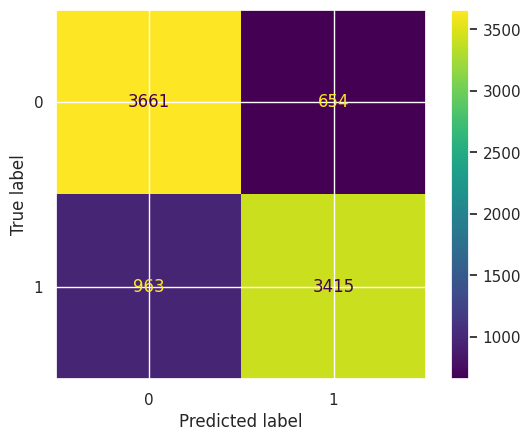

In [51]:
# OOF accuracy (already have oof_blend & best_t)           
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

oof_preds = (oof_blend >= best_t)
oof_acc   = accuracy_score(y, oof_preds)
print(f"OOF accuracy (5-fold blend) : {oof_acc:.4f}")

# Optional sanity-check: confusion-matrix on the training folds
cm = confusion_matrix(y, oof_preds)
ConfusionMatrixDisplay(cm).plot(values_format="d")

# Inner-slice accuracy   (10 % slice used for early-stop)  
# Probabilities on the inner validation slice
p_cat_val = cat_final.predict_proba(X_val)[:, 1]
p_lgb_val = lgb_final.predict(
    X_val, num_iteration=lgb_final.best_iteration
)
p_xgb_val = xgb_final.predict_proba(X_val)[:, 1]

proba_val = w_cat*p_cat_val + w_lgb*p_lgb_val + w_xgb*p_xgb_val
val_preds = (proba_val >= best_t)
val_acc   = accuracy_score(y_val, val_preds)
print(f"Inner-slice accuracy         : {val_acc:.4f}")

# Agreement check  (± 1 percentage point)                 
diff = abs(oof_acc - val_acc)

if diff <= 0.01:
    print(f"✓ Accuracies agree within ±1 pp (Δ = {diff:.4f})")
else:
    print(f"⚠ Difference > 1 pp (Δ = {diff:.4f}) — investigate drift/leakage")

## Interpret the ensemble with SHAP

1. Compute SHAP values for each base learner on the same feature matrix.
2. Blend them with the learned weights (w ₁, w ₂, w ₃).
3. Visualise the weighted SHAP matrix.

The figure layout has changed to tight


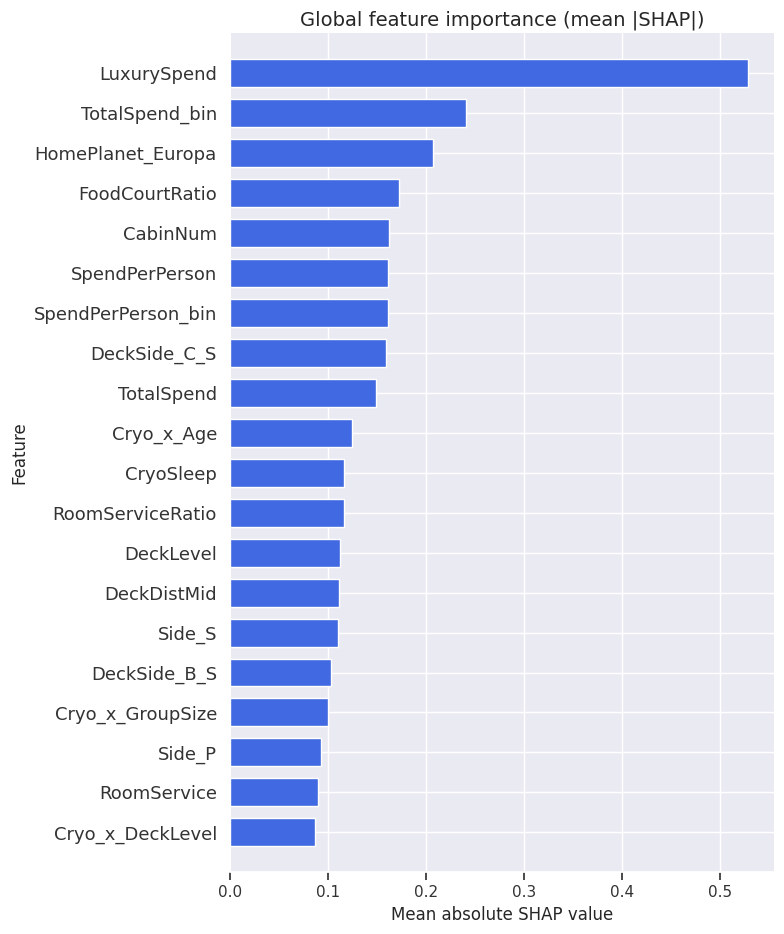

The figure layout has changed to tight


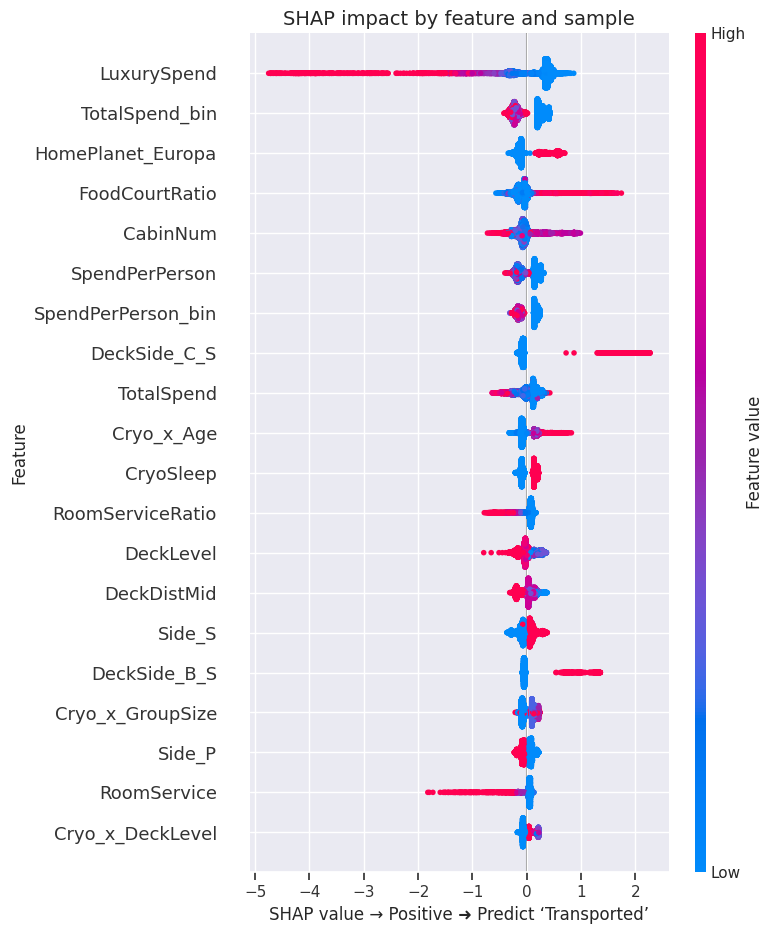

In [54]:
import shap

# TreeExplainers (use training data for background)
expl_cat = shap.TreeExplainer(cat_final)
expl_lgb = shap.TreeExplainer(lgb_final)
expl_xgb = shap.TreeExplainer(xgb_final)

# SHAP matrices on the full-train set
shap_cat = expl_cat.shap_values(X_train_all)
shap_lgb = expl_lgb.shap_values(X_train_all)[1]
shap_xgb = expl_xgb.shap_values(X_train_all)

# Weight-average them
shap_ens = (
    w_cat * shap_cat +
    w_lgb * shap_lgb +
    w_xgb * shap_xgb
)

# Plot – summary bar & beeswarm
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(
    shap_ens, X_train_all,
    feature_names=tfm.get_feature_names_out(),
    plot_type="bar",
    show=False,    # keep control to tweak labels
    color="royalblue"
)
ax.set_title("Global feature importance (mean |SHAP|)", fontsize=14)
ax.set_xlabel("Mean absolute SHAP value", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(
    shap_ens, X_train_all,
    feature_names=tfm.get_feature_names_out(),
    show=False
)
ax.set_title("SHAP impact by feature and sample", fontsize=14)
ax.set_xlabel("SHAP value → Positive ➜ Predict ‘Transported’", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Ablation Study

In [ ]:
# NUM_FOLDS   = 5
# MAX_K       = 80          # test first 30 least-important columns (adjust)

# base_params = {
#     "objective": "binary",
#     "metric":    "binary_logloss",
#     "verbosity": -1,
#     "device_type": "gpu",
# }

# sgkf = StratifiedGroupKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# #  Fit ONE full model to rank features
# tfm_full = SpaceshipTransformer(min_freq=0.01)          # no post-drop yet
# X_all    = tfm_full.fit_transform(X)
# dtrain   = lgb.Dataset(X_all, label=y)

# model_full = lgb.train(
#     base_params,
#     dtrain,
#     num_boost_round=1000
# )

# gain          = model_full.feature_importance(importance_type="gain")
# feat_names    = np.array(model_full.feature_name())
# feat_ranking  = feat_names[np.argsort(gain)]            # low → high gain

# # Ablation curve
# results = []

# for k in range(0, min(MAX_K, len(feat_ranking)) + 1):   # drop 0 … k features
#     to_drop = feat_ranking[:k].tolist()                 # k least-important
#     accs    = []

#     # brand-new transformer that hides those dummies
#     tfm_k = SpaceshipTransformer(
#         min_freq=0.01,
#         drop_cols=to_drop
#     )

#     for tr_idx, va_idx in sgkf.split(X, y, groups):
#         # fit / transform
#         X_tr  = tfm_k.fit_transform(X.iloc[tr_idx])
#         X_val = tfm_k.transform(X.iloc[va_idx])
#         y_tr, y_val = y[tr_idx], y[va_idx]

#         # train / score
#         m = lgb.train(
#             base_params,
#             lgb.Dataset(X_tr, label=y_tr),
#             num_boost_round=1000
#         )

#         acc = accuracy_score(y_val, m.predict(X_val) > 0.5)
#         accs.append(acc)

#     results.append((k, np.mean(accs)))
#     print(f"dropped {k:2d} → CV acc = {np.mean(accs):.4f}")

# # Plot
# ks, scores = zip(*results)
# plt.plot(ks, scores, marker="o")
# plt.xlabel("# dummy features dropped")
# plt.ylabel("Mean CV accuracy")
# plt.title("LightGBM ablation curve")
# plt.gca().invert_xaxis();           # optional: 0 → left, more drops → right
# plt.show()

# Data Submission

In [55]:
# Transform test split
X_test_all  = tfm.transform(test)

# Probabilities on test
p_cat_te = cat_final.predict_proba(X_test_all)[:, 1]
p_lgb_te = lgb_final.predict(X_test_all,  num_iteration=lgb_final.best_iteration)
p_xgb_te = xgb_final.predict_proba(X_test_all)[:, 1]

# Blend with the Optuna weights
proba_te  = w_cat*p_cat_te + w_lgb*p_lgb_te + w_xgb*p_xgb_te

# Predict on test & write submission
preds_test = (proba_te >= best_t).astype(bool)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": preds_test
})
submission.to_csv("submission.csv", index=False)

print("✓ submission.csv written.")

✓ submission.csv written.
